Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 60%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000206901s, CPU 0.005594s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00778533s, CPU 0.04204s)
Info    : 395 nodes 793 elements
Triangle 3


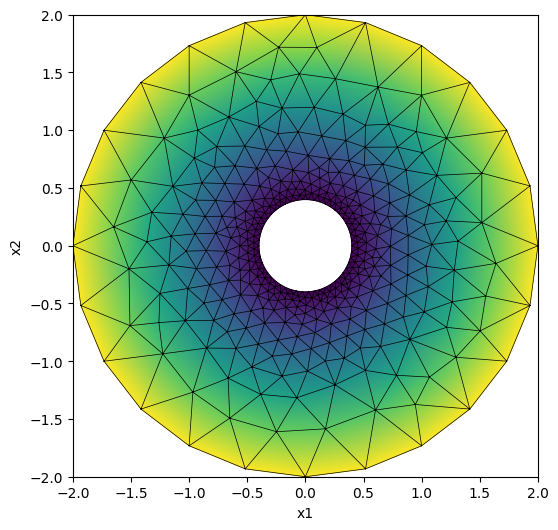

In [1]:
import meshBuilder
import matplotlib.pyplot as plt
import numpy as np
import distanceField

mesh0, b0 = meshBuilder.buildMesh_tri_cylinder_gmsh(
    x0=[0, 0], r_inner=0.4, r_outer=2, lc=0.5, lc_inner=0.05
)
d0 = distanceField.get_mesh_nodal_wall_distance(mesh0, b0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mesh0.plot_image(ax=ax, v=d0, v_type="N")
mesh0.plot_grid(ax=ax, linewidth=0.5, color="k")

mesh1 = meshBuilder.SimplexMeshShifted(mesh0.nodes, mesh0.simplices)
mesh1.off[:] = np.array([[1, 0]])
b1 = b0.copy()

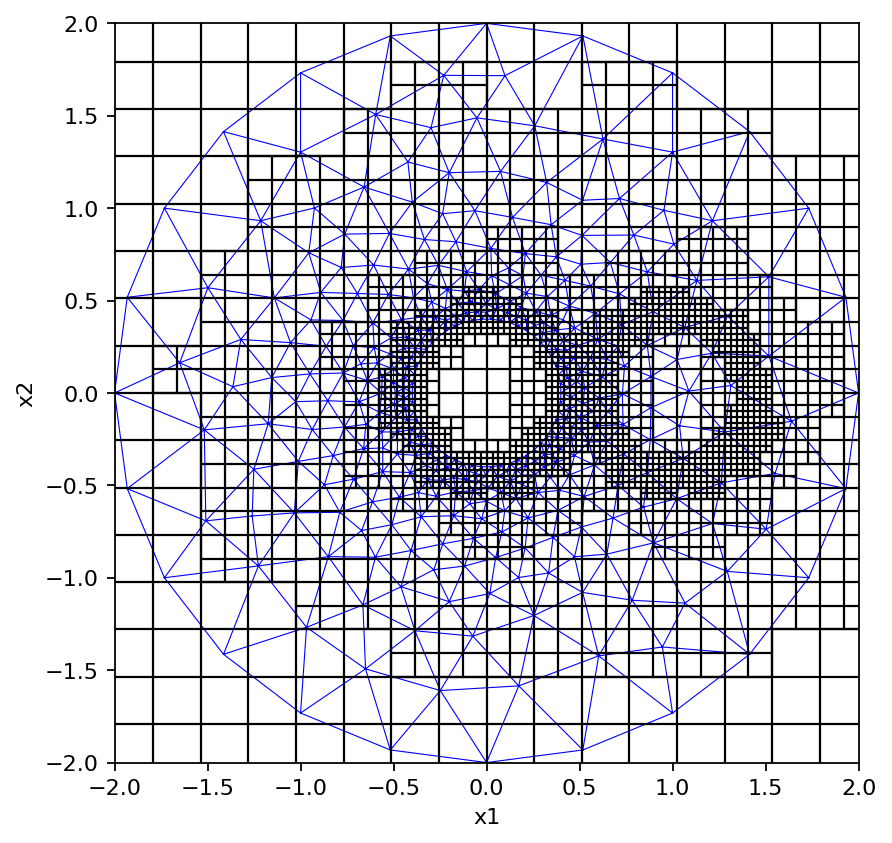

In [2]:
import meshHelper

h0 = 0.001
meshB, nLevel = meshBuilder.buildMesh_quadTree(h0, h0, 100, 100)
meshHelper.refine_tree_mesh_by_tri(meshB, h0, nLevel, mesh0)
meshHelper.refine_tree_mesh_by_tri(meshB, h0, nLevel, mesh1)

meshB.finalize()

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111)
meshB.plot_grid(ax=ax, color="k", linewidth=1.0)
mesh0.plot_grid(ax=ax, color="b", linewidth=0.5)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.grid(False)

[array([1, 3, 5, 6]), array([0, 2, 3]), array([  1, 445,   4]), array([0, 4, 1, 9]), array([  3, 447,   2,  10,  11]), array([6, 0, 7]), array([5, 9, 0, 8]), array([   8,    5, 1403]), array([   7,   14,   16,    6, 1404]), array([ 6, 10, 12,  3, 14, 15]), array([ 9, 11,  4, 12]), array([ 10, 450,   4,  13]), array([ 9, 13, 10, 18]), array([ 12, 452,  11,  19,  20]), array([ 8, 15,  9, 16]), array([14, 18,  9, 17]), array([   8,   17,   14, 1407]), array([  16,   23,   25,   15, 1408]), array([15, 19, 21, 12, 23, 24]), array([18, 20, 13, 21]), array([ 19, 455,  13,  22]), array([18, 22, 19, 27]), array([ 21, 457,  20,  28,  29]), array([17, 24, 18, 25]), array([23, 27, 18, 26]), array([  17,   26,   23, 1411]), array([  25,   32,   34,   24, 1412]), array([24, 28, 30, 21, 32, 33]), array([27, 29, 22, 30]), array([ 28, 460,  22,  31]), array([27, 31, 28, 36, 37]), array([ 30, 462,  29,  40,  41]), array([26, 33, 27, 34]), array([32, 36, 38, 27, 35]), array([  26,   35,   32, 1415]), arr

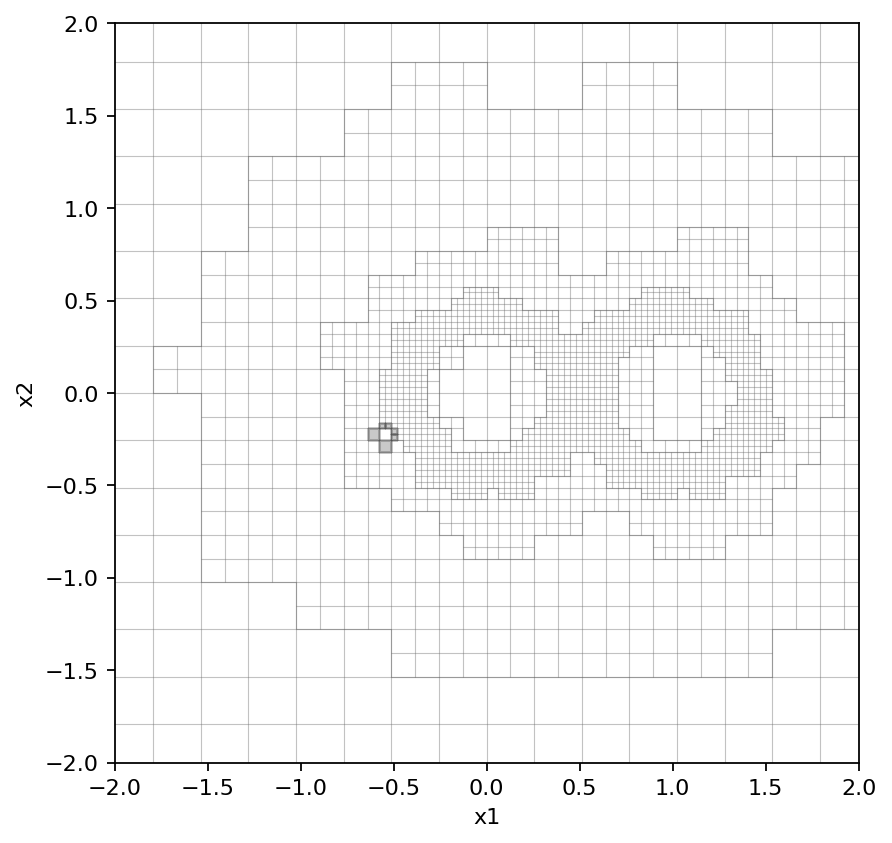

In [3]:
import meshPlotUtils

B_cell2cell = meshHelper.get_tree_adj_face(meshB, h0)

fig = plt.figure(124, figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111)
iBCheck = 259
print(B_cell2cell)
meshPlotUtils.plot_mesh_mono(
    meshB,
    ax=ax,
    cell_mask=np.isin(np.arange(meshB.n_cells), B_cell2cell[iBCheck]),
    # cell_mask=np.asarray([v.size > 0 for v in M0_cells_on_B], dtype=np.bool),
    linecolor="#43434352",
    facecolor="#43434349",
)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.grid(False)

[259 262 264 379 380 385 387]


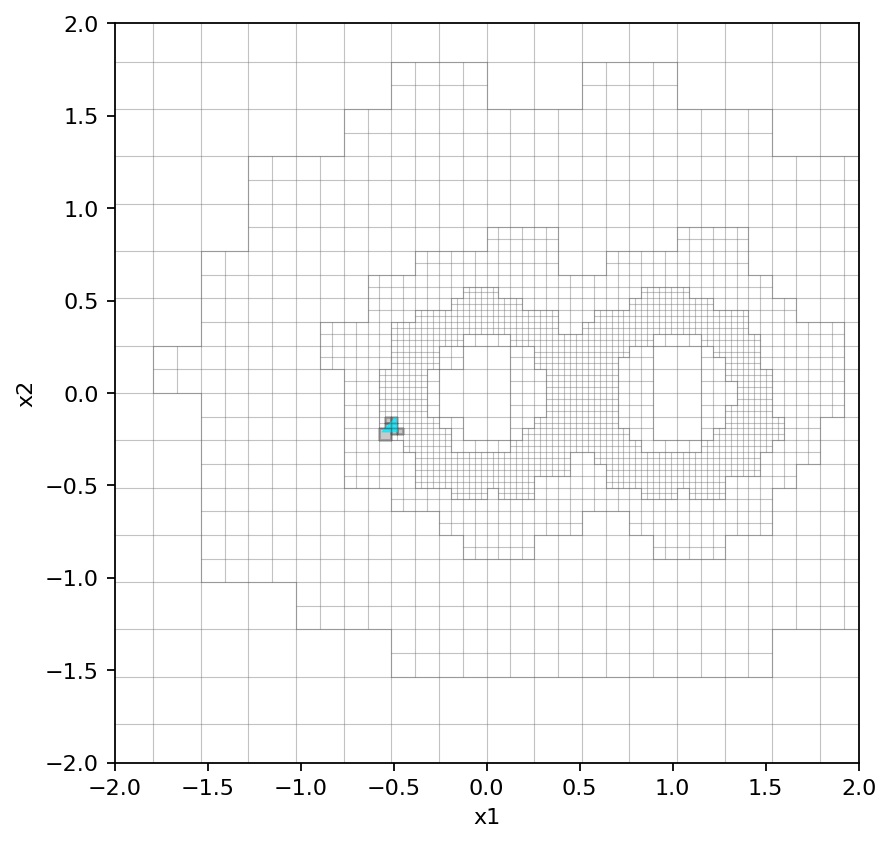

In [4]:
B_cells_on_M0, M0_cells_on_B = meshHelper.get_tri_to_tree_intersect(meshB, mesh0)


iM0Check = 128
print(B_cells_on_M0[iM0Check])
fig = plt.figure(123, figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111)
meshPlotUtils.plot_mesh_mono(
    meshB,
    ax=ax,
    cell_mask=np.isin(np.arange(meshB.n_cells), B_cells_on_M0[iM0Check]),
    # cell_mask=np.asarray([v.size > 0 for v in M0_cells_on_B], dtype=np.bool),
    linecolor="#43434352",
    facecolor="#43434349",
)
meshPlotUtils.plot_mesh_mono(
    mesh0,
    ax=ax,
    cell_mask=np.isin(np.arange(mesh0.n_cells), np.asarray([iM0Check])),
    linecolor="#00FFFB00",
)

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.grid(False)

array([0, 0, 0, ..., 0, 0, 0], shape=(2782,), dtype=int32)

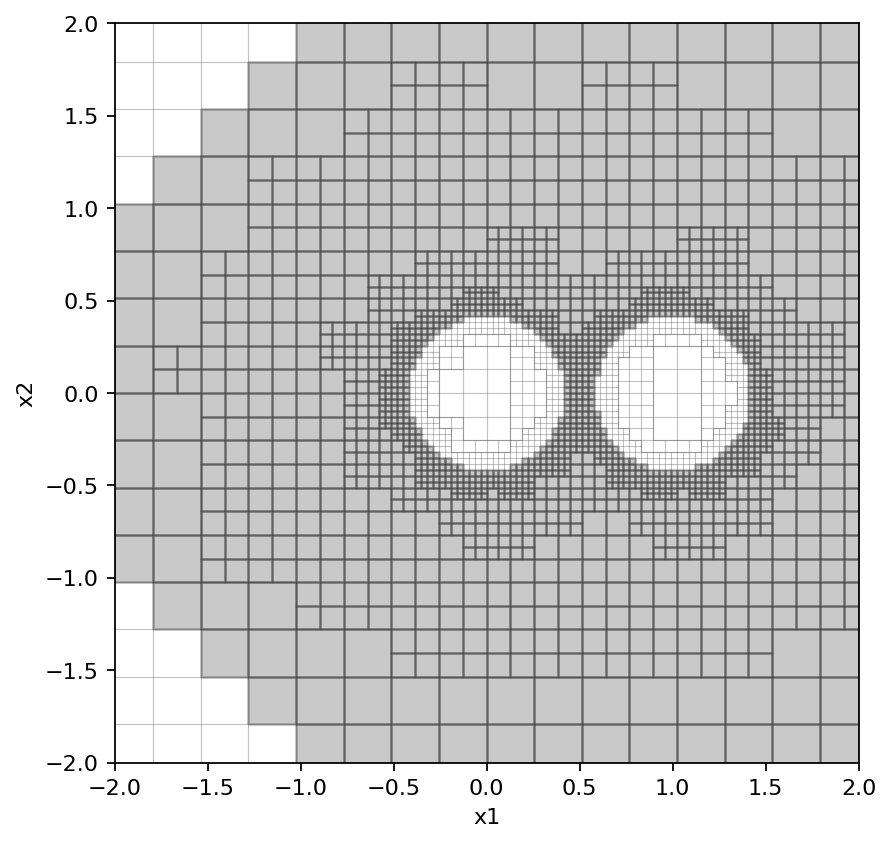

In [5]:
import chimeraTree2D_Helper
from chimeraTree2D_Helper import FGMesh, MeshCellConn

meshes = [FGMesh(mesh0, b0), FGMesh(mesh1, b1)]
conns = [
    MeshCellConn(
        *(
            meshHelper.get_tri_to_tree_intersect(meshB, mesh.mesh)
            + meshHelper.get_tribnd_to_tree_intersect(meshB, mesh.mesh, mesh.b)
        )
    )
    for mesh in meshes
]

fluid_solid_B = chimeraTree2D_Helper.chimeraMeshBHole2DTreeTri(
    meshB, meshes, B_cell2cell, conns
)
fig = plt.figure(124, figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111)
meshPlotUtils.plot_mesh_mono(
    meshB,
    ax=ax,
    cell_mask=fluid_solid_B == 1,
    linecolor="#43434352",
    facecolor="#43434349",
)
# meshPlotUtils.plot_mesh_mono(
#     mesh0,
#     ax=ax,
#     cell_mask=np.isin(np.arange(mesh0.n_cells), np.asarray([iM0Check])),
#     linecolor="#00FFFB00",
# )

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.grid(False)
fluid_solid_B

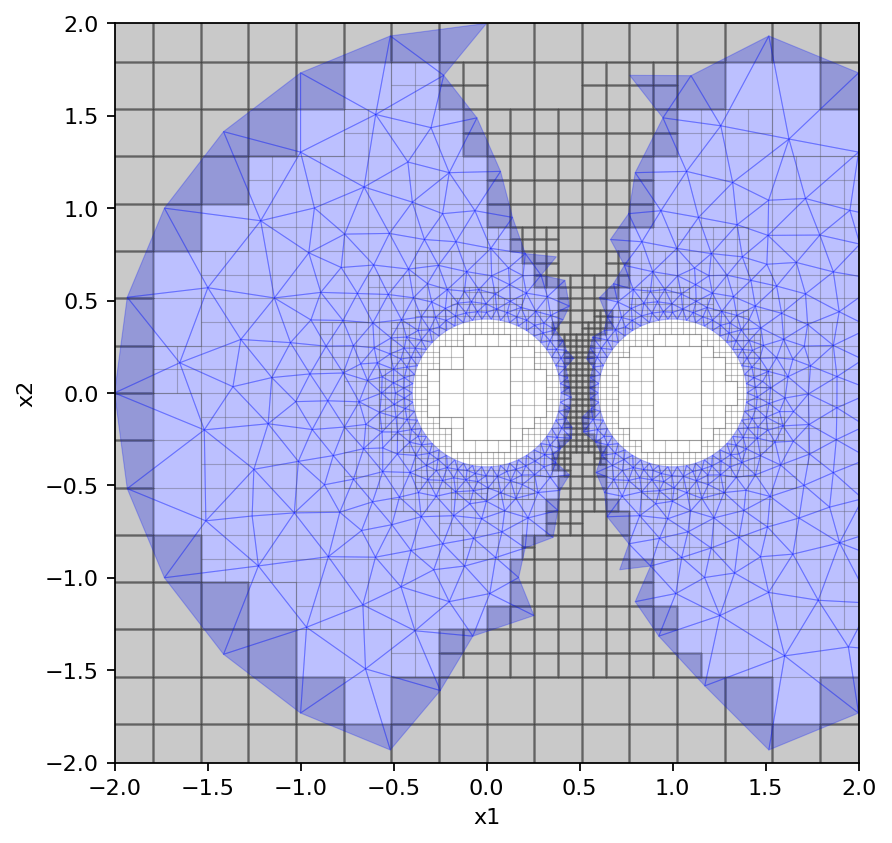

In [6]:
holeB, holes = chimeraTree2D_Helper.chimeraHole2DTreeTri(
    meshB, meshes, fluid_solid_B, B_cell2cell, conns
)

fig = plt.figure(125, figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111)
meshPlotUtils.plot_mesh_mono(
    meshB,
    ax=ax,
    cell_mask=holeB,
    linecolor="#43434352",
    facecolor="#43434349",
)
for mesh, hole in zip(meshes, holes):
    meshPlotUtils.plot_mesh_mono(
        mesh.mesh,
        ax=ax,
        cell_mask=hole,
        linecolor="#00000000",
        facecolor="#0011FF43"
    )

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.grid(False)